## Data Mining Project Report (part 02)

Topic: Bank Marketting


Name : S. M. Shakila Arafat Chy

In [2]:
# importing requierd libraries
import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings('ignore')

In [3]:
Data = pd.read_csv("bank-full.csv", sep = ";")

In [4]:
Data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
Data.shape

(45211, 17)

In [6]:
df = Data.sample(frac = 0.1, random_state = 2022)  # sampling of dataset

In [7]:
df.shape

(4521, 17)

In [8]:
# Remove columns by ignoring case
df1 = df.drop(columns=['emp.var.rate', 'euribor3m'], axis=1, errors='ignore')


In [9]:
df1.shape

(4521, 17)

In [10]:
numerical = df1.select_dtypes(exclude = ['object'])      # dataset with numerical attributes
categorical = df1.select_dtypes(include = ['object'])    # dataset with category attributes

In [11]:
from sklearn.preprocessing import LabelEncoder

# Assuming 'categorical' is your DataFrame or Series with categorical data
le = LabelEncoder()
le_categorical = categorical.apply(le.fit_transform)


In [12]:
le_categorical.head()

,job,marital,education,default,housing,loan,contact,month,poutcome,y
32785,0,1,1,0,1,0,0,0,3,0
21230,3,1,3,0,0,0,0,1,3,0
24242,7,1,1,0,1,0,0,9,3,0
2404,1,0,1,0,1,0,2,8,3,1
13305,1,1,0,0,0,0,0,5,3,0


In [13]:
df2 = pd.concat([numerical, le_categorical], axis = 1, join = 'inner')  # combining two dataframes 
df2.head()

,age,balance,day,duration,campaign,pdays,previous,job,marital,education,default,housing,loan,contact,month,poutcome,y
32785,35,437,17,123,1,-1,0,0,1,1,0,1,0,0,0,3,0
21230,60,5421,18,458,4,-1,0,3,1,3,0,0,0,0,1,3,0
24242,43,3305,17,387,1,-1,0,7,1,1,0,1,0,0,9,3,0
2404,34,383,13,2231,1,-1,0,1,0,1,0,1,0,2,8,3,1
13305,57,0,8,237,3,-1,0,1,1,0,0,0,0,0,5,3,0


In [14]:
# Convert dataframe to matrix
dfMatrix = df1.to_numpy()

In [15]:
scaler = StandardScaler().fit(numerical)     # standardize the input data

In [16]:
X_scaled = scaler.transform(numerical)
Numer_scaled = pd.DataFrame(X_scaled, columns = numerical.columns)
Numer_scaled.head()

,age,balance,day,duration,campaign,pdays,previous
0,-0.558124,-0.345978,0.139736,-0.506965,-0.592745,-0.412035,-0.288625
1,1.819636,1.504361,0.261483,0.717193,0.424514,-0.412035,-0.288625
2,0.202759,0.718784,0.139736,0.457744,-0.592745,-0.412035,-0.288625
3,-0.653235,-0.366025,-0.347253,7.196091,-0.592745,-0.412035,-0.288625
4,1.534305,-0.508216,-0.955990,-0.090386,0.085428,-0.412035,-0.288625


In [17]:
df_scaled = pd.concat([Numer_scaled, le_categorical], axis = 1, join = 'inner')

In [18]:
df_scaled.head()

,age,balance,day,duration,campaign,pdays,previous,job,marital,education,default,housing,loan,contact,month,poutcome,y
2,0.202759,0.718784,0.139736,0.457744,-0.592745,-0.412035,-0.288625,2,1,1,0,1,1,2,8,3,0
30,-0.272793,-0.469606,-1.199484,1.258014,0.085428,-0.412035,-0.288625,9,1,1,0,0,1,2,8,3,0
59,-0.748345,-0.508216,0.991967,-0.196358,-0.592745,-0.412035,-0.288625,7,1,0,0,1,0,2,8,3,0
73,0.392980,-0.508216,1.235462,0.702576,-0.253658,-0.412035,-0.288625,1,1,0,0,1,0,2,8,3,0
89,-0.843455,-0.508216,0.383231,-0.269442,-0.253658,-0.412035,-0.288625,5,1,1,0,1,0,2,8,3,0


### Identifying Optimum Number of Clusters

In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def find_optimal_value(data, max_k):  
    means = []
    inertias = []
    
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        
        means.append(k)
        inertias.append(kmeans.inertia_)
        
    fig, ax = plt.subplots(figsize=(10, 8))  # generate the elbow plot
    ax.plot(means, inertias, 'o-', color='b')
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel('Inertia')
    ax.grid(True)
    ax.set_title('Elbow Results')
    plt.show()

# Example usage:
# find_optimal_value(your_data, max_k_value)


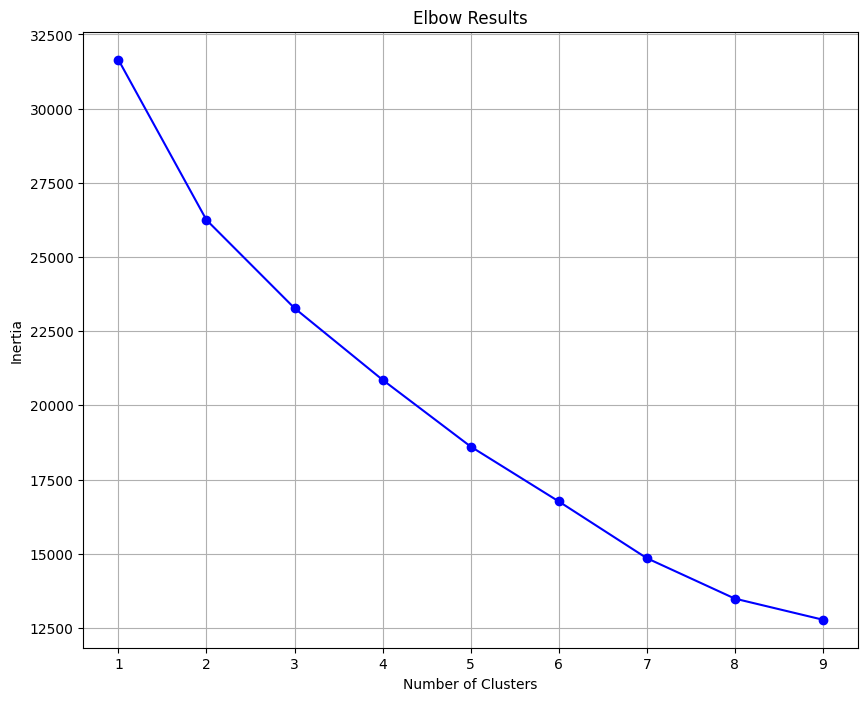

In [20]:
find_optimal_value(Numer_scaled, 10)

In [21]:
from sklearn.metrics import silhouette_score

In [22]:
SK = range(2,11)

sil_score = []
for k in SK:
    labels = KMeans(n_clusters=k,random_state=2023).fit(Numer_scaled).labels_
    score = silhouette_score(Numer_scaled, labels, metric="euclidean", sample_size=1000,random_state=2023)
    sil_score.append(score)
    

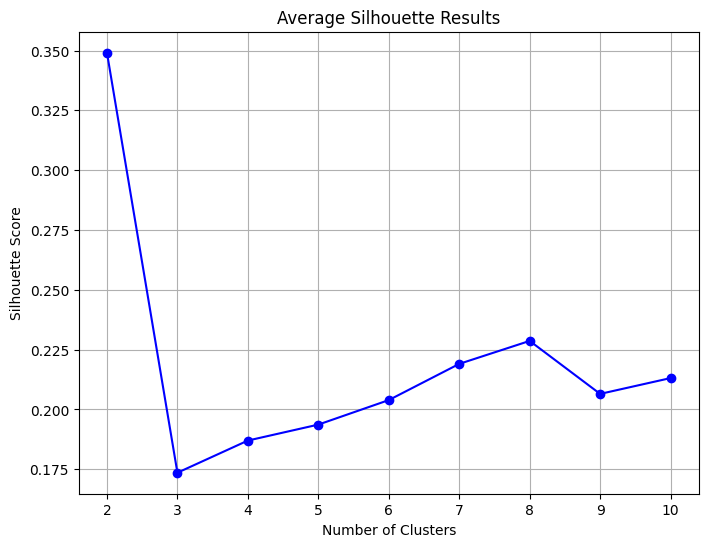

In [23]:
fig = plt.subplots(figsize = (8, 6))    # generate the silhouette plot
plt.plot(SK, sil_score, 'o-', color = 'b')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.title('Average Silhouette Results')
plt.show()

### Implement k-Mean

In [24]:
kmean4 = KMeans(n_clusters = 4)

In [25]:
kmean4.fit(Numer_scaled)

KMeans(n_clusters=4)

In [26]:
numerical.shape

(4521, 7)

In [27]:
numerical['cluster'] = kmean4.labels_

In [28]:
numerical.tail()

,age,balance,day,duration,campaign,pdays,previous,cluster
35133,30,122,7,219,2,-1,0,1
5137,31,664,21,987,3,-1,0,2
37378,55,1691,13,358,2,174,1,0
5662,42,-245,26,63,1,-1,0,2
32728,40,224,17,875,2,-1,0,1


In [29]:
numerical['cluster'].value_counts()

cluster
1    1941
2    1734
0     666
3     180
Name: count, dtype: int64

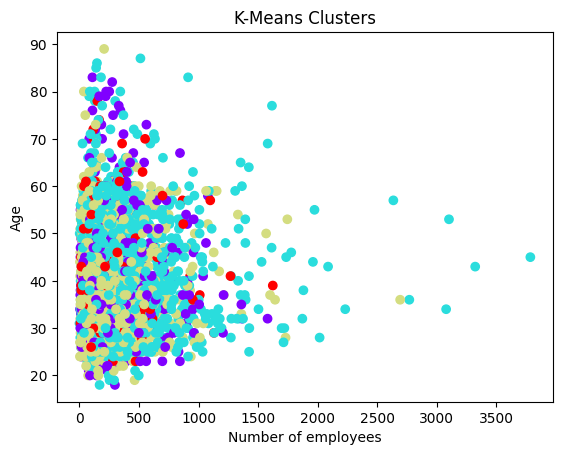

In [30]:
plt.scatter(numerical['duration'], numerical['age'], c = numerical['cluster'], cmap = 'rainbow')
plt.xlabel('Number of employees')
plt.ylabel('Age')
plt.title('K-Means Clusters')
plt.show()


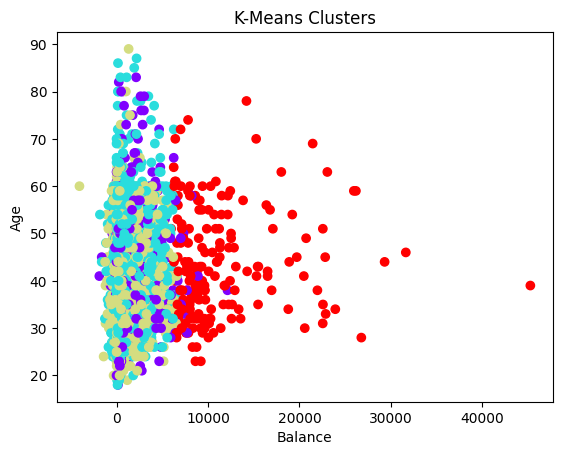

In [31]:
plt.scatter(numerical['balance'], numerical['age'], c=numerical['cluster'], cmap='rainbow')
plt.xlabel('Balance')
plt.ylabel('Age')
plt.title('K-Means Clusters')
plt.show()


In [32]:
from sklearn.decomposition import PCA

# Assuming 'numerical' is your DataFrame containing the numerical columns
data_for_pca = numerical.drop('cluster', axis=1)  # Exclude the 'cluster' column if it's present

pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_for_pca)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Add the 'cluster' column back to the DataFrame if needed
pca_df['cluster'] = numerical['cluster']

In [33]:
pca = PCA(2)       #  For dimensional reduction

In [34]:
pca1 = pca.fit_transform(numerical)
pca1.shape

(4521, 2)

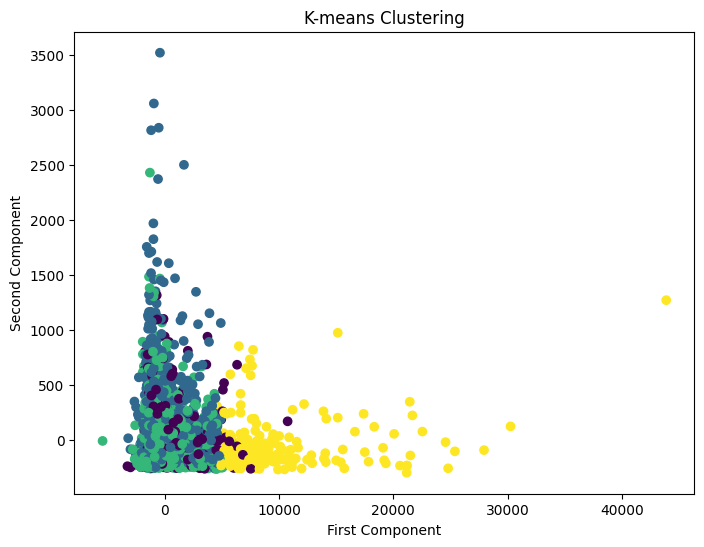

In [35]:
plt.figure(figsize = (8,6))
plt.scatter(pca1[:, 0], pca1[:, 1], c = numerical['cluster'])
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.title('K-means Clustering')
plt.show()

In [36]:
y = le_categorical.y

In [37]:
import numpy as np                     # purity_score function
from sklearn import metrics     

def purity_score(y_true, y_pred):
                                                                    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
                                                                                 # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

In [38]:
purity_score(y, numerical['cluster'])

0.8838752488387525

### Implementation of K-Modes Clustering

In [39]:
from kmodes.kmodes import KModes

In [40]:
le_categorical1 = le_categorical.drop('y', axis = 1)   #   drop column with labels

In [41]:
le_categorical1.head()

,job,marital,education,default,housing,loan,contact,month,poutcome
32785,0,1,1,0,1,0,0,0,3
21230,3,1,3,0,0,0,0,1,3
24242,7,1,1,0,1,0,0,9,3
2404,1,0,1,0,1,0,2,8,3
13305,1,1,0,0,0,0,0,5,3


In [42]:
cost = []
for num_clusters in list(range(1,7)):                                             # optimal number of clusters
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=1)
    kmode.fit_predict(le_categorical1)
    cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters


Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 15908.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 702, cost: 13325.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 824, cost: 12433.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1057, cost: 11593.0
Run 1, iteration: 2/100, moves: 154, cost: 11593.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1064, cost: 11424.0
Run 1, iteration: 2/100, moves: 218, cost: 11424.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1120, cost: 10954.0
Run 1, iteration: 2/100, moves: 217, cost: 10954.0


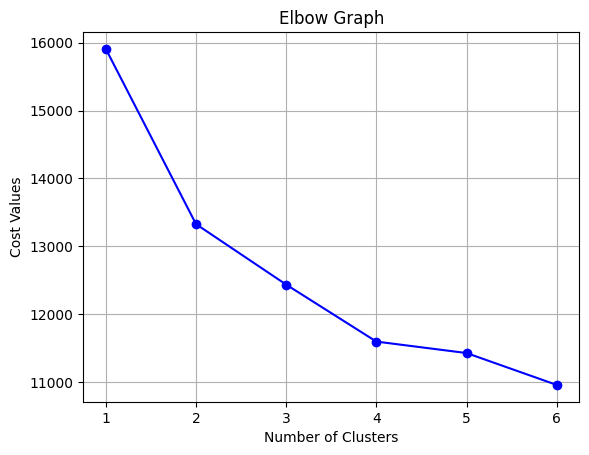

In [43]:
x = np.array([i for i in range(1,7,1)])
plt.plot(x,cost, 'o-', color = 'b')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost Values')
plt.title('Elbow Graph')
plt.grid(True)
plt.show()

In [44]:
SK = range(2,11)

sil_score = []
for k in SK:
    labels = KModes(n_clusters=k,random_state=2023, init = "Cao", n_init = 1, verbose=1).fit(le_categorical1).labels_
    score = silhouette_score(le_categorical1, labels, metric="euclidean", sample_size=1000,random_state=2023)
    sil_score.append(score)
    

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 702, cost: 13325.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 824, cost: 12433.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1057, cost: 11593.0
Run 1, iteration: 2/100, moves: 154, cost: 11593.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1064, cost: 11424.0
Run 1, iteration: 2/100, moves: 218, cost: 11424.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1120, cost: 10954.0
Run 1, iteration: 2/100, moves: 217, cost: 10954.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1156, cost: 10789.0
Run 1, iteration: 2/100, moves: 176, cost: 10789.0
Init: 

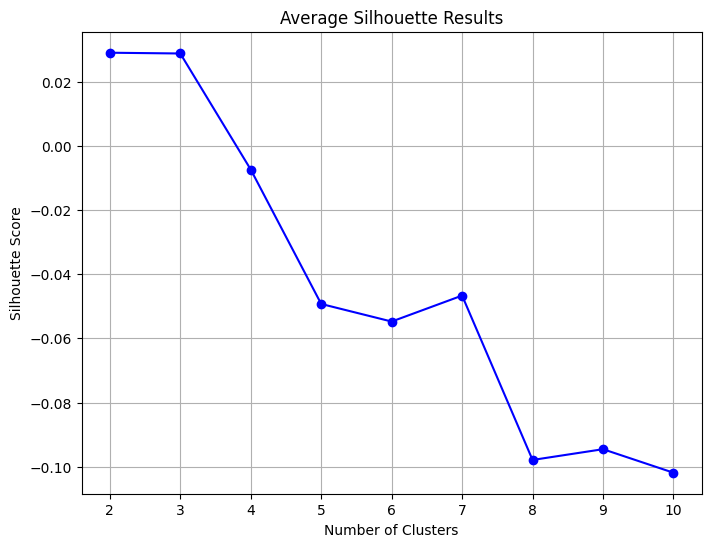

In [45]:
fig = plt.subplots(figsize = (8, 6))    # generate the silhouette plot
plt.plot(SK, sil_score, 'o-', color = 'b')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.title('Average Silhouette Results')
plt.show()

In [46]:
kmodes = KModes(n_clusters=3,random_state=2023, init = "Cao", n_init = 1, verbose=1)
kmodes.fit(le_categorical)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 852, cost: 13345.0


KModes(n_clusters=3, n_init=1, random_state=2023, verbose=1)

In [47]:
le_categorical['clusters'] = kmodes.labels_

In [48]:
le_categorical['clusters'] = kmodes.labels_

In [49]:
le_categorical.head()

,job,marital,education,default,housing,loan,contact,month,poutcome,y,clusters
32785,0,1,1,0,1,0,0,0,3,0,0
21230,3,1,3,0,0,0,0,1,3,0,2
24242,7,1,1,0,1,0,0,9,3,0,0
2404,1,0,1,0,1,0,2,8,3,1,0
13305,1,1,0,0,0,0,0,5,3,0,0


<Axes: xlabel='clusters'>

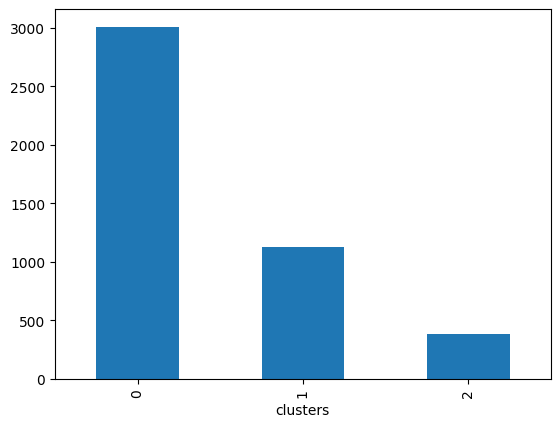

In [50]:
le_categorical.clusters.value_counts().plot(kind = 'bar')

In [51]:
cols = ['default', 'contact', 'month', 'housing']

In [52]:
le_cat = le_categorical.drop(cols, axis = 1)
le_cat.head()

,job,marital,education,loan,poutcome,y,clusters
32785,0,1,1,0,3,0,0
21230,3,1,3,0,3,0,2
24242,7,1,1,0,3,0,0
2404,1,0,1,0,3,1,0
13305,1,1,0,0,3,0,0


In [53]:
le_cat['age'] = df['age']

In [54]:
le_cat.groupby('marital')['clusters'].count()

marital
0     539
1    2652
2    1330
Name: clusters, dtype: int64

In [55]:
import plotly.offline as py
import plotly.graph_objs as go

In [56]:
trace1 = go.Scatter3d(
    x= le_cat['education'],
    y= le_cat['marital'],
    z= le_cat['age'],
    mode='markers',
     marker=dict(
        color = le_cat['clusters'], 
        size= 10,
        opacity=0.8
     )
)
df = [trace1]

layout = go.Layout(
    title = 'Age vs Marital vs Education',
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0  
    ),
    scene = dict(
            xaxis = dict(title  = 'education'),
            yaxis = dict(title  = 'marital'),
            zaxis = dict(title  = 'age')
        )
)

fig = go.Figure(data = df, layout = layout)
py.iplot(fig)

In [57]:
purity_score(y, le_cat['clusters'])

0.8984737889847378

### Clustering by AGNES

In [58]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist,squareform

In [59]:
df2_ag = df2.drop('y', axis = 1)

In [60]:
scaler1 = StandardScaler().fit(df2_ag)
df2_agscaled = scaler1.fit_transform(df2_ag)

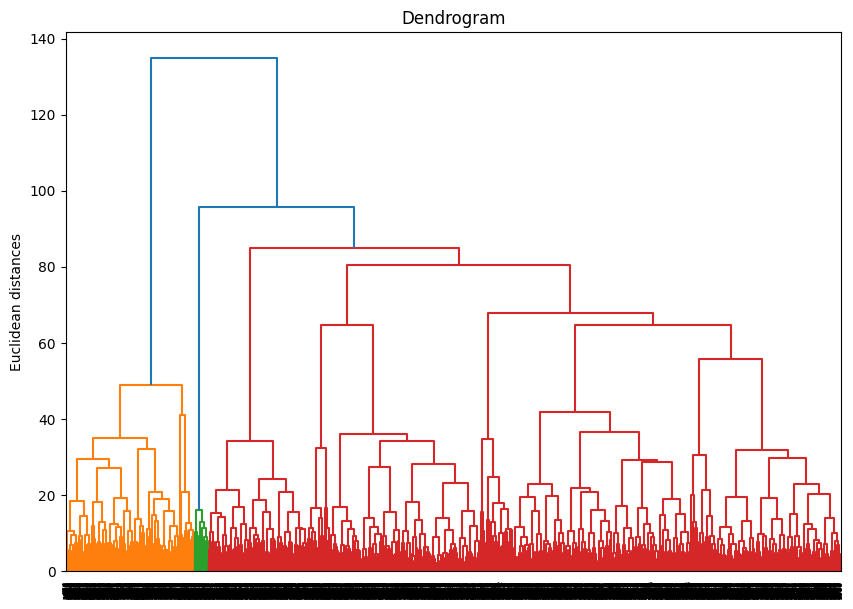

In [61]:
import scipy.cluster.hierarchy as sch
plt.figure(figsize = (10, 7))

dendro = sch.dendrogram(sch.linkage(df2_agscaled, method = 'ward'))
plt.title('Dendrogram')
plt.ylabel('Euclidean distances')
plt.show()

In [62]:
from sklearn.cluster import AgglomerativeClustering


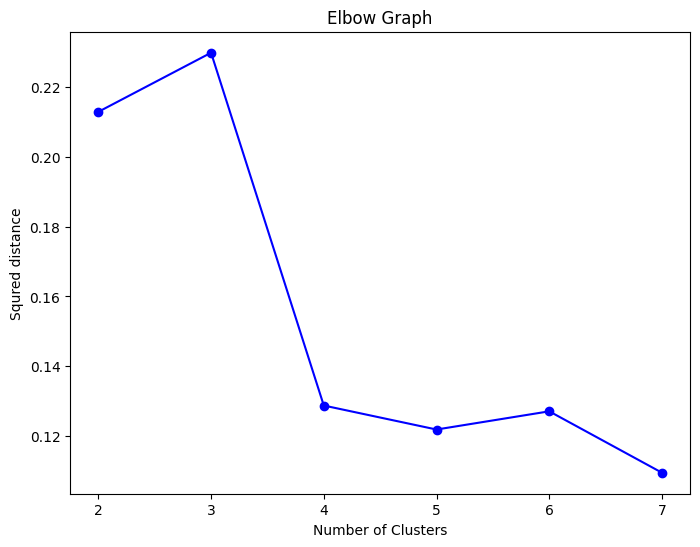

In [63]:
n_clusters = np.arange(2, 8)
scores = []

for n in n_clusters:
    model = AgglomerativeClustering(n_clusters=n, affinity = 'euclidean', linkage = 'ward')
    labels = model.fit_predict(df2_agscaled)
    score = silhouette_score(df2_agscaled, labels)
    scores.append(score)
plt.figure(figsize= (8,6))
plt.plot(n_clusters, scores, 'o-', color = 'b')
plt.xlabel('Number of Clusters')
plt.ylabel('Squred distance')
plt.title('Elbow Graph')
plt.show()

In [64]:

cluster = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
cluster.fit_predict(df2_agscaled)

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [65]:
cl_ag = cluster.fit_predict(df2_agscaled)

In [66]:
silhouette_score(df2_agscaled, cl_ag)

0.22989805522874807

In [67]:
cl_ag

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [68]:

df2['cluster'] = cl_ag
purity_score(y, df2['cluster'])

0.8838752488387525

In [69]:
df2.head()

,age,balance,day,duration,campaign,pdays,previous,job,marital,education,default,housing,loan,contact,month,poutcome,y,cluster
32785,35,437,17,123,1,-1,0,0,1,1,0,1,0,0,0,3,0,0
21230,60,5421,18,458,4,-1,0,3,1,3,0,0,0,0,1,3,0,0
24242,43,3305,17,387,1,-1,0,7,1,1,0,1,0,0,9,3,0,0
2404,34,383,13,2231,1,-1,0,1,0,1,0,1,0,2,8,3,1,0
13305,57,0,8,237,3,-1,0,1,1,0,0,0,0,0,5,3,0,0


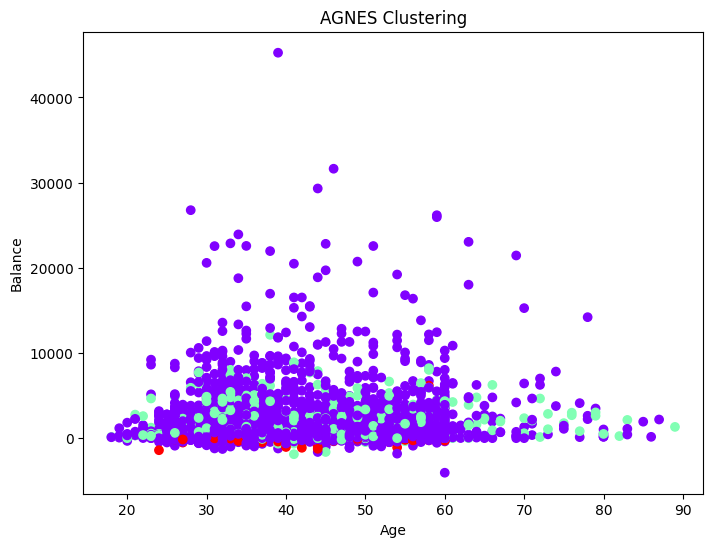

In [70]:
plt.figure(figsize=(8, 6))
plt.scatter(df2['age'], df2['balance'], c=df2['cluster'], cmap='rainbow')
plt.xlabel('Age')
plt.ylabel('Balance')
plt.title('AGNES Clustering')
plt.show()


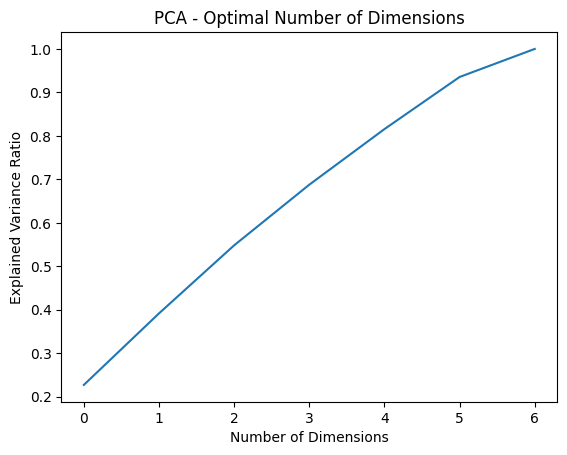

In [71]:
# Load the data
X = Numer_scaled

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Plot the explained variance ratio as a function of the number of dimensions
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Dimensions')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA - Optimal Number of Dimensions')
plt.show()
